# Data Loading

In [7]:
import os
import pandas as pd
data_dir = './../DataFiles/StreamingDataWithLabels/' #note to modify directory if changes
files = os.listdir(data_dir)
print(f'data files: {files}')
dfs = []
for file in files:
    if file.endswith(".xlsx"):
        df = pd.read_excel(data_dir + file, header=None)
    elif file.endswith(".csv"):
        df = pd.read_csv(data_dir + file,engine='python', header=None)
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)
#First col is label, second col is text
df.columns=['label','comment']

# Remove missing values, duplicate values and abnormal samples
df = df.dropna()
df = df.drop_duplicates()
df = df[df['label'].isin([0.0,'-1',-1.0, 1.0,'0','1'])]

df['label'] = df['label'].astype('int')

print(f"Number of labels in the training set:\n {df['label'].value_counts()}")

data files: ['annotations_pos.csv', 'Neg1.csv', 'Neg2.xlsx', 'objective1.csv', 'Objective_2.csv', 'Positive1.csv', 'positive_2.csv']
Number of labels in the training set:
 -1    4396
 0    3708
 1    2323
Name: label, dtype: int64


In [8]:
df['label'] = df['label'].replace(0, 1) 
print(f"The labels after combination:\n{df['label'].value_counts()}")
df

The labels after combination:
 1    6031
-1    4396
Name: label, dtype: int64


,label,comment
0,1,@realDonaldTrump Asian Americans will encounte...
1,1,@Fight4_Freedumb @Whyaduck @ClueHeywood @realD...
2,1,"Let there be no mistake, China is not responsi..."
3,1,THIS IS SO F*** RACIST! WTF I?�?m so pissed! R...
4,1,@JJamesMIA @LatimerJane @pumpkin_yuleimy @eeka...
...,...,...
39462,1,They were called Coolie (鑻﹀姏锛? They set a reco...
39465,1,Ok i'm asian and i have to hear things like th...
39471,1,"America鈥檚 caste system harms everyone, but God..."
39472,1,I fear the falling Chinese spacecraft with onl...


# Data Exploring

In [9]:
# header defaultly presents 5 lines
df.head()

,label,comment
0,1,@realDonaldTrump Asian Americans will encounte...
1,1,@Fight4_Freedumb @Whyaduck @ClueHeywood @realD...
2,1,"Let there be no mistake, China is not responsi..."
3,1,THIS IS SO F*** RACIST! WTF I?�?m so pissed! R...
4,1,@JJamesMIA @LatimerJane @pumpkin_yuleimy @eeka...


In [11]:
# View the distribution of samples
count = len(df['label'])
count_negative_one = df.loc[df['label'] == -1]
number_of_negative_ones = len(count_negative_one)
count_one = df.loc[df['label'] == 1]
number_of_ones = len(count_one)

print(' Total amount of examples:', count, "\n", 'Total number of label=1: ',
      number_of_ones, "\n", "Total number of label=-1: ", number_of_negative_ones)

 Total amount of examples: 10427 
 Total number of label=1:  6031 
 Total number of label=-1:  4396


# Visualize the distribution

Text(0.5, 1.0, 'label distribution')

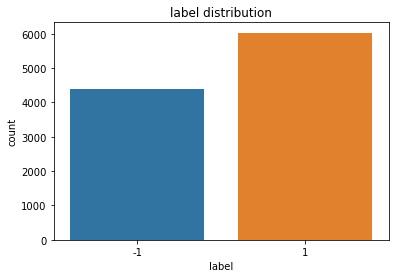

In [12]:
import seaborn as sns
sns.countplot(x='label', data=df).set_title('label distribution')

Text(0.5, 1.0, 'label distribution')

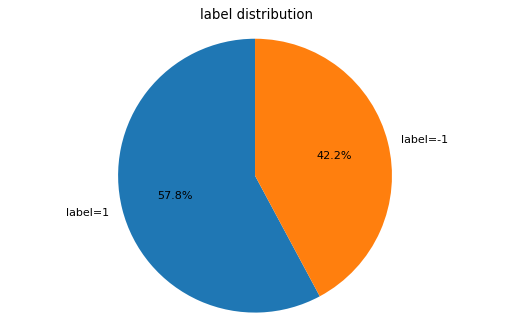

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
numbers =  [number_of_ones, number_of_negative_ones]
explode = None
labels= ['label=1', 'label=-1']
plt.pie(numbers, explode =explode, labels = labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('label distribution')

# Text data cleaning

In [15]:
from nltk.corpus import stopwords
import string
import re
from nltk import *

# Load stopwords
stop_words = stopwords.words('english')
# Add some other words
#stop_words.append("https")

porter = PorterStemmer()
def remove_noise(text):
    tokens = word_tokenize(text) # Participate
    tokens =[porter.stem(t) for t in tokens]  # stemmer
    tokens_filtered = [w for w in tokens if w.lower() not in stop_words and w.lower() not in string.punctuation] # Filter abnoarmal words
    return " ".join(tokens_filtered)

df['comment_pre'] = df['comment'].apply(remove_noise)
df.head()

,label,comment,comment_pre
0,1,@realDonaldTrump Asian Americans will encounte...,realdonaldtrump asian american encount discrim...
1,1,@Fight4_Freedumb @Whyaduck @ClueHeywood @realD...,fight4_freedumb whyaduck clueheywood realdonal...
2,1,"Let there be no mistake, China is not responsi...",let mistak china respons chinaviru everyon us ...
3,1,THIS IS SO F*** RACIST! WTF I?�?m so pissed! R...,thi F racist wtf � piss republican call � chin...
4,1,@JJamesMIA @LatimerJane @pumpkin_yuleimy @eeka...,jjamesmia latimerjan pumpkin_yuleimi eekamax 1...


# Construct Training and Testing sets

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X, y = df['comment_pre'].to_numpy(), df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f'X_train size:{X_train.shape[0]}, X_test size:{X_test.shape[0]}')

# manually construct text features, construct Tfidf statistical features
vect = TfidfVectorizer(ngram_range=(2, 2), max_features=5000)

X_train_Tfidf = vect.fit_transform(X_train)
X_test_Tfidf = vect.transform(X_test)
X_train_Tfidf.shape

X_train size:9384, X_test size:1043


(9384, 5000)

# SVM model

In [17]:
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# Create a svm Classifier
clf = svm.SVC(kernel='rbf')  # rbf Kernel
# Train the model using the training sets
clf.fit(X_train_Tfidf, y_train)
# Predict the class for train dataset
predict_train = clf.predict(X_train_Tfidf)

print('---------------------Training Set--------------------')
print(f"Confusion matrix:\n {confusion_matrix(y_train, predict_train)}")
print(f"Indicator statistics:\n {classification_report(y_train, predict_train)}")
print()
print('---------------------Testing Set---------------------')
# Test the performance on testing set
predict_test = clf.predict(X_test_Tfidf)
print(f"Confusion matrix:\n {confusion_matrix(y_test, predict_test)}")
print(f"Indicator statistics:\n {classification_report(y_test, predict_test)}")

---------------------Training Set--------------------
Confusion matrix:
 [[3552  394]
 [  88 5350]]
Indicator statistics:
               precision    recall  f1-score   support

          -1       0.98      0.90      0.94      3946
           1       0.93      0.98      0.96      5438

    accuracy                           0.95      9384
   macro avg       0.95      0.94      0.95      9384
weighted avg       0.95      0.95      0.95      9384


---------------------Testing Set---------------------
Confusion matrix:
 [[364  86]
 [ 37 556]]
Indicator statistics:
               precision    recall  f1-score   support

          -1       0.91      0.81      0.86       450
           1       0.87      0.94      0.90       593

    accuracy                           0.88      1043
   macro avg       0.89      0.87      0.88      1043
weighted avg       0.88      0.88      0.88      1043



# Naive Bayes model

In [18]:
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# Create a naive_bayes Classifier
clf = MultinomialNB() 
# Train the model using the training sets
clf.fit(X_train_Tfidf.toarray(), y_train)
# Predict the class for train dataset
predict_train = clf.predict(X_train_Tfidf.toarray())

print('---------------------Training Set--------------------')
print(f"Confusion matrix:\n {confusion_matrix(y_train, predict_train)}")
print(f"Indicator statistics:\n {classification_report(y_train, predict_train)}")
print()
print('---------------------Testing Set---------------------')
# Test the performance on testing set
predict_test = clf.predict(X_test_Tfidf)
print(f"Confusion matrix:\n {confusion_matrix(y_test, predict_test)}")
print(f"Indicator statistics:\n {classification_report(y_test, predict_test)}")

---------------------Training Set--------------------
Confusion matrix:
 [[3383  563]
 [ 181 5257]]
Indicator statistics:
               precision    recall  f1-score   support

          -1       0.95      0.86      0.90      3946
           1       0.90      0.97      0.93      5438

    accuracy                           0.92      9384
   macro avg       0.93      0.91      0.92      9384
weighted avg       0.92      0.92      0.92      9384


---------------------Testing Set---------------------
Confusion matrix:
 [[367  83]
 [ 37 556]]
Indicator statistics:
               precision    recall  f1-score   support

          -1       0.91      0.82      0.86       450
           1       0.87      0.94      0.90       593

    accuracy                           0.88      1043
   macro avg       0.89      0.88      0.88      1043
weighted avg       0.89      0.88      0.88      1043



# Single-layer CNN model

We try to use a single-layer CNN structure to deal with text classification problems. First, through an Embedding layer, the dimensionality is reduced to a 20-bit vector, and then a one-dimensional CNN layer with a filter number of 20 and a step size of 1 is used for processing, and then a pooling layer is connected. In order to prevent over-fitting, 50% of the data is randomly lost between the CNN layer and the fully connected layer for training. It needs to be pointed out that the Embedding layer is equivalent to temporarily calculating the word vector, converting the original word sequence into a word vector sequence of a specified dimension.

In [19]:
import jieba
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

text = df['comment_pre'].tolist()
labels = df['label'].tolist()

MAX_FEATURES = 5000 #Max dict
MAX_DOCUMENT_LENGTH = 20 #max doc length

# Convert text to number
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
X = pad_sequences(sequences, maxlen=MAX_DOCUMENT_LENGTH)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print("X_train:", X_train)
print("y_train:", y_train)

9384 train sequences
1043 test sequences
X_train: [[  10 1778 2030 ...    3    2    1]
 [  81    6  313 ...    3    2    1]
 [   0    0    0 ...  117    8   90]
 ...
 [   0    0    0 ...   12   62  122]
 [  34   40  315 ...    3    2    1]
 [   0    0    0 ...   48  254 3514]]
y_train: [1 1 0 ... 0 0 1]


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Activation, Input, MaxPooling1D, Flatten, concatenate, Embedding, Dropout

BATCH_SIZE = 128
NUM_CLASSES = 3
EPOCH = 15
# CNN parameters
embedding_dims = 20
filters = 20
kernel_size = 3
hidden_dims = 250

model = Sequential()
# word embedding layer
model.add(Embedding(MAX_FEATURES, embedding_dims))

# Convolutional layer
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# pooling layer
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.5))

# fully connected layer
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCH,
          validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE)
print("loss: {}, accuracy:{}".format(loss, accuracy))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          100000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 20)          1220      
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 63        
Total params: 101,283
Trainable params: 101,283
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
74/74 [==============================] - 11s 10ms/step - loss: 1.0271 - accuracy: 0.5400 - val_loss: 0.72

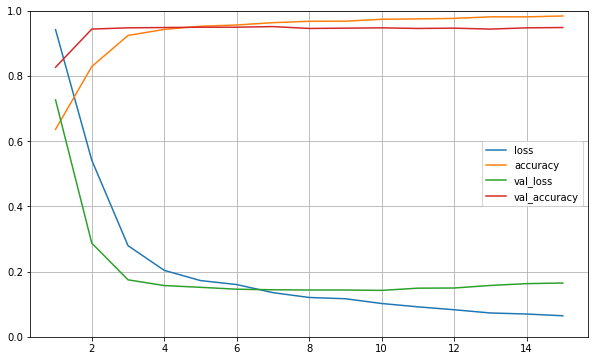

In [21]:
# plot loss and accuracy with epoch
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
def plot_learning_curves(history):
    pd.DataFrame(history.history, index=range(1,EPOCH+1)).plot(figsize=(10, 6))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

The model is over-fitting after the 8th epoch, and the accuracy rate of the single-layer CNN model can reach 81%

# TextCNN model

TextCNN is an algorithm that uses convolutional neural networks to classify text. It was proposed by Yoon Kim. It essentially uses one-dimensional convolutions of sizes 3, 4, and 5 to process text data. The text data here can be a fixed-length bag-of-words sequence model, or a word vector can be used.

In [22]:
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Activation, Input, MaxPooling1D, Flatten, concatenate, Embedding, Dropout
from keras import regularizers

BATCH_SIZE = 128
NUM_CLASSES = 3
EPOCH = 15

# CNN parameters
embedding_dims = 50
filters = 10

# Inputs
input = Input(shape=[MAX_DOCUMENT_LENGTH])

# Embeddings layers
x = Embedding(MAX_FEATURES, embedding_dims)(input)

# conv layers
convs = []
for filter_size in [3, 4, 5]:
    l_conv = Conv1D(filters=filters, kernel_size=filter_size, activation='relu')(x)
    l_pool = MaxPooling1D()(l_conv)
    l_pool = Flatten()(l_pool)
    convs.append(l_pool)

merge = concatenate(convs, axis=1)

out = Dropout(0.5)(merge)

out = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(out)

output = Dense(units=NUM_CLASSES, activation='softmax')(out)

# Output Layer
model = Model([input], output)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCH,
          validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE)
print("loss: {}, accuracy:{}".format(loss, accuracy))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 50)       250000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 10)       1510        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 17, 10)       2010        embedding_1[0][0]                
______________________________________________________________________________________________

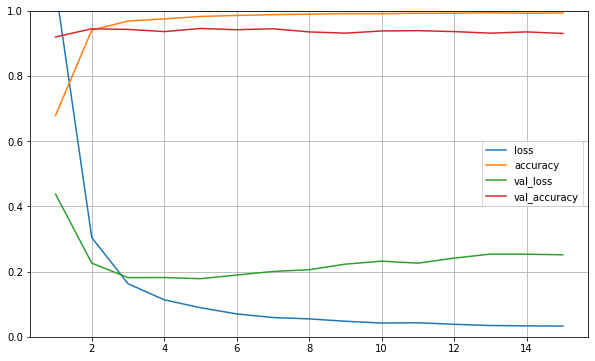

In [23]:
# plot loss and accuracy with epoch

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
def plot_learning_curves(history):
    pd.DataFrame(history.history, index=range(1,EPOCH+1)).plot(figsize=(10, 6))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# BERT (Bidirectional Encoder Representations from Transformers)

Finally, we tried the most popular BERT model in the current NLP field. BERT provides a model for other task migration learning. This model can be fine-tuned or fixed according to the task as a feature extractor. With the help of BERT, it can be used on fewer samples. It can also be fine-tuned for better results.

In [15]:
import numpy as np
import torch
from sklearn import metrics
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

X, y = df['comment_pre'].tolist(), df['label'].tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.1, random_state=123)
train_texts[0:5], train_labels[0:5]

(['despit histor victori aapi candid legisl we鈥檙 still far reflect democraci strategi implement greater divers represent US elector system aapiheritagemonth genderaveng http //t.co/z3kynm03a9',
  'happi aapiheritagemonth amaz pacif island asian american love hope amaz month i鈥檒l continu spread resourc ili 馃�� 鉂わ笍 http //t.co/tscjpenlyg',
  'nhl china entir respons global pandem denouncechina makechinapay wuhanflu chinaviru letstalkaboutchina chineseliar communist communistchina china chinaliedpeopledi',
  'globaltimesnew world weari beast spread chineseviru gloat pandemic_in_india lowlif xijinp',
  'harrykoolo april51581 mustwesuff mike_p ccpviru drlimengyan1 covid19 takedowntheccp covid19 wuhanviru antidot pompeo ccp want challeng statu u.s. energi independ u.s. sensit strength world stage http //t.co/yzho3mcnji http //t.co/onmnn54hov'],
 array([2, 2, 0, 0, 0], dtype=int64))

In [16]:
# Load bert participle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [17]:
# Define input data
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [18]:
#Define the bert model, because the downstream is a classification task, 
#select BertForSequenceClassification for fine-tuning
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=len(np.unique(train_labels)))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
# define train、evaluate、test support functions
def train(config, model, train_iter, dev_iter):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    total_batch = 0  # Record batches
    dev_best_loss = float('inf')
    last_improve = 0  # Record the number of batches that the loss of the last validation set dropped
    flag = False  # Whether the record has not been improved for a long time
    for epoch in range(config.num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, config.num_epochs))
        for i, batch in enumerate(train_iter):
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optim.step()
            print(f'Batch: {i}, Loss: {loss.detach().numpy()}')
            if total_batch % 10 == 0:
                # How many rounds of output the effect on the training set and validation set
                true = labels.data.cpu().numpy()
                predict = outputs.logits.argmax(axis=1).cpu().numpy()
                train_acc = metrics.accuracy_score(true, predict)
                dev_acc, dev_loss = evaluate(config, model, dev_iter)
                if dev_loss < dev_best_loss:
                    dev_best_loss = dev_loss
                    improve = '*'
                    last_improve = total_batch
                else:
                    improve = ''
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.4},  Train Acc: {2:>6.4%},  Val Loss: {3:>5.4},  Val Acc: {4:>6.4%},  {5}'
                print(msg.format(total_batch, loss.item(), train_acc, dev_loss, dev_acc, improve))
                model.train()
            total_batch += 1
            if total_batch - last_improve > config.require_improvement:
                # Verify that the loss of the validation set exceeds 1000batch and does not drop. End the training
                print("No optimization for a long time, auto-stopping...")
                flag = True
                break
        if flag:
            break
    test(config, model, dev_loader)
    

def evaluate(config, model, data_iter, test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    with torch.no_grad():
        for batch in data_iter:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss.cpu().numpy()
            loss_total += loss
            labels = labels.data.cpu().numpy()
            predict = outputs.logits.argmax(axis=1).cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predict)

    acc = metrics.accuracy_score(labels_all, predict_all)
    if test:
        report = metrics.classification_report(labels_all, predict_all, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total / len(data_iter), report, confusion
    return acc, loss_total / len(data_iter)


def test(config, model, test_iter):
    model.eval()
    test_acc, test_loss, test_report, test_confusion = evaluate(config, model, test_iter, test=True)
    msg = 'Test Loss: {0:>5.4},  Test Acc: {1:>6.4%}'
    print(msg.format(test_loss, test_acc))
    print("Precision, Recall and F1-Score...")
    print(test_report)
    print("Confusion Matrix...")
    print(test_confusion)

In [ ]:
# Training model
class Config:
    learning_rate = 0.0001
    num_epochs = 2
    require_improvement = 1000

config = Config()

train(config, model, train_loader, test_loader)